In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

### Helper functions (dcm)

In [2]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

### Preprocessing (dcm to npy)

In [5]:
# Some constants
TRAINVAL = 'stage1'
INPUT_FOLDER = '../data/data-science-bowl/dcm/{}'.format(TRAINVAL)
OUTPUT_FOLDER = '../data/data-science-bowl/npy/{}'.format(TRAINVAL)
LABEL_FILE = '../data/data-science-bowl/dcm/{}_labels.csv'.format(TRAINVAL)
df_labels = pd.read_csv(LABEL_FILE)
patients = df_labels['id'].values
labels = df_labels['cancer'].values

In [ ]:
def preprocessing(path):
    patient = load_scan(path)
    patient_pixels = get_pixels_hu(patient)
    pix_resampled, spacing = resample(patient_pixels, patient, [1,1,1])
    print("HU converting: ({}, {}) "
          "--> ({}, {})".format(np.amin(patient[0].pixel_array),
                                np.amax(patient[0].pixel_array),
                                np.amin(patient_pixels),
                                np.amax(patient_pixels)))
    print("Shape resampling: {} --> {}".format(patient_pixels.shape,
                                               pix_resampled.shape))
    return pix_resampled

from multiprocessing import Pool

def f(p):
    img_path = os.path.join(INPUT_FOLDER, p)
    pix_resampled = preprocessing(img_path)
    output_path = os.path.join(OUTPUT_FOLDER, p)
    np.save(output_path, pix_resampled)
    return pix_resampled.shape

pool = Pool(processes=8)
results = pool.map(f, patients)

HU converting: (-2000, 2254) --> (-1024, 1790)
Shape resampling: (114, 512, 512) --> (142, 394, 394)
HU converting: (-1024, 2282) --> (-2048, 2138)
Shape resampling: (130, 512, 512) --> (325, 369, 369)
HU converting: (-2000, 2341) --> (-1024, 1750)
Shape resampling: (170, 512, 512) --> (340, 340, 340)
HU converting: (0, 2396) --> (-1024, 2087)
Shape resampling: (170, 512, 512) --> (340, 364, 364)
HU converting: (0, 2471) --> (-1024, 1662)
Shape resampling: (172, 512, 512) --> (310, 380, 380)
HU converting: (-2000, 2374) --> (-1024, 1597)
Shape resampling: (252, 512, 512) --> (315, 319, 319)
HU converting: (-2000, 4095) --> (-1024, 3071)
Shape resampling: (195, 512, 512) --> (390, 355, 355)
HU converting: (0, 2158) --> (-1024, 1683)
Shape resampling: (220, 512, 512) --> (330, 380, 380)
HU converting: (0, 2734) --> (-1024, 2260)
Shape resampling: (152, 512, 512) --> (304, 324, 324)
HU converting: (0, 2256) --> (-1024, 2940)
Shape resampling: (178, 512, 512) --> (356, 340, 340)
HU convert

/home/jihong/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


HU converting: (-2000, 2337) --> (-1024, 3071)
Shape resampling: (277, 512, 512) --> (346, 365, 365)
HU converting: (-2000, 2682) --> (-1024, 1815)
Shape resampling: (187, 512, 512) --> (234, 280, 280)
HU converting: (-2048, 1635) --> (-2048, 2689)
Shape resampling: (154, 512, 512) --> (308, 290, 290)
HU converting: (-2000, 2306) --> (-1024, 1743)
Shape resampling: (139, 512, 512) --> (278, 345, 345)
HU converting: (0, 2338) --> (-1024, 1801)
Shape resampling: (162, 512, 512) --> (324, 340, 340)
HU converting: (0, 2424) --> (-1024, 2053)
Shape resampling: (166, 512, 512) --> (332, 372, 372)
HU converting: (0, 2465) --> (-1024, 1815)
Shape resampling: (191, 512, 512) --> (344, 350, 350)
HU converting: (-2048, 1484) --> (-2048, 2276)
Shape resampling: (161, 512, 512) --> (290, 412, 412)
HU converting: (-2000, 2408) --> (-1024, 2180)
Shape resampling: (173, 512, 512) --> (346, 360, 360)
HU converting: (0, 2513) --> (-1024, 1804)
Shape resampling: (150, 512, 512) --> (270, 318, 318)
HU con

/home/jihong/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


HU converting: (-2000, 2381) --> (-1024, 1640)
Shape resampling: (95, 512, 512) --> (238, 290, 290)
HU converting: (0, 2405) --> (-1024, 3028)
Shape resampling: (172, 512, 512) --> (344, 320, 320)
HU converting: (0, 2464) --> (-1024, 1809)
Shape resampling: (165, 512, 512) --> (330, 360, 360)
HU converting: (-2000, 2349) --> (-1024, 2022)
Shape resampling: (259, 512, 512) --> (324, 363, 363)
HU converting: (-1024, 1236) --> (-1024, 3071)
Shape resampling: (117, 512, 512) --> (292, 350, 350)
HU converting: (-2000, 2512) --> (-1024, 2407)
Shape resampling: (273, 512, 512) --> (341, 360, 360)
HU converting: (-2048, 1800) --> (-2048, 2690)
Shape resampling: (149, 512, 512) --> (298, 290, 290)
HU converting: (0, 2852) --> (-1024, 3071)
Shape resampling: (383, 512, 512) --> (383, 332, 332)
HU converting: (-2000, 2520) --> (-1024, 3072)
Shape resampling: (265, 512, 512) --> (331, 400, 400)
HU converting: (-1024, 1307) --> (-1024, 3071)
Shape resampling: (140, 512, 512) --> (350, 350, 350)
HU 

In [ ]:
# Some constants
TRAINVAL = 'stage1'
INPUT_FOLDER = '../data/data-science-bowl/dcm/{}'.format(TRAINVAL)
OUTPUT_FOLDER = '../data/data-science-bowl/npy/{}'.format(TRAINVAL)
LABEL_FILE = '../data/data-science-bowl/dcm/stage1_sample_submission.csv'
df_labels = pd.read_csv(LABEL_FILE)
patients = df_labels['id'].values
labels = df_labels['cancer'].values
def preprocessing(path):
    patient = load_scan(path)
    patient_pixels = get_pixels_hu(patient)
    pix_resampled, spacing = resample(patient_pixels, patient, [1,1,1])
    print("HU converting: ({}, {}) "
          "--> ({}, {})".format(np.amin(patient[0].pixel_array),
                                np.amax(patient[0].pixel_array),
                                np.amin(patient_pixels),
                                np.amax(patient_pixels)))
    print("Shape resampling: {} --> {}".format(patient_pixels.shape,
                                               pix_resampled.shape))
    return pix_resampled

from multiprocessing import Pool

def f(p):
    img_path = os.path.join(INPUT_FOLDER, p)
    pix_resampled = preprocessing(img_path)
    output_path = os.path.join(OUTPUT_FOLDER, p)
    np.save(output_path, pix_resampled)
    return pix_resampled.shape

pool_test = Pool(processes=8)
results_test = pool_test.map(f, patients)

### Visualization

HU converting: (-2000, 4095) --> (-1024, 3071)
Shape resampling: (195, 512, 512) --> (390, 355, 355)


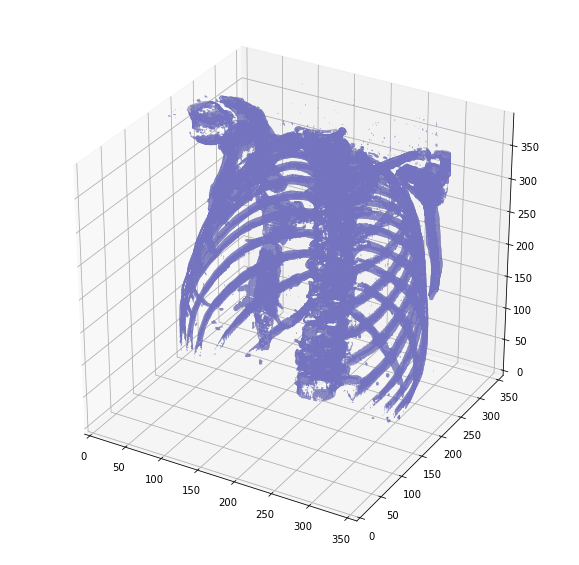

In [20]:
def preprocessing(path):
    patient = load_scan(path)
    patient_pixels = get_pixels_hu(patient)
    pix_resampled, spacing = resample(patient_pixels, patient, [1,1,1])
    print("HU converting: ({}, {}) "
          "--> ({}, {})".format(np.amin(patient[0].pixel_array),
                                np.amax(patient[0].pixel_array),
                                np.amin(patient_pixels),
                                np.amax(patient_pixels)))
    print("Shape resampling: {} --> {}".format(patient_pixels.shape,
                                               pix_resampled.shape))
    return pix_resampled
    
p = patients[0]
img_path = os.path.join(INPUT_FOLDER, p)
pix_resampled = preprocessing(img_path)
plot_3d(pix_resampled, 400)

### Preprocessing (nii to nii.fixed)

In [10]:
import nipy as ni
from nipy.core.api import AffineTransform as AfT, Image, vox2mni
import nibabel as nib
from nipy.labs.datasets.volumes.volume_img import VolumeImg

In [11]:
# Some constants 
TRAINVAL = 'sample_images'
INPUT_FOLDER = '../data/data-science-bowl/nii/{}'.format(TRAINVAL)
OUTPUT_FOLDER = '../data/data-science-bowl/nii_fixed/{}'.format(TRAINVAL)
LABEL_FILE = '../data/data-science-bowl/nii/{}_labels.csv'.format(TRAINVAL)
TARGET_SIZE = (224, 224, 224)
df_labels = pd.read_csv(LABEL_FILE)
patients = df_labels['id'].values
labels = df_labels['cancer'].values

In [12]:
from scipy import stats
def preprocessing(ipath, target_size):
    # load
    img = ni.load_image(ipath)
    # resampling
    vol_img = VolumeImg(data=img.get_data(), affine=np.eye(4),
                        world_space='')
    resampled_img = vol_img.as_volume_img(affine=np.eye(4),
                                          shape=target_size,
                                         interpolation='nearest')
    out_img = Image(resampled_img.get_data(), img.coordmap)
    patient_pixels = img.get_data().astype('int16')
    pix_resampled = out_img.get_data().astype('int16')
    print("Pixel median: {} --> {}".format(
        np.median(patient_pixels),
        np.median(pix_resampled)))
    print("Pixel mean: {} --> {}".format(
        np.mean(patient_pixels),
        np.mean(pix_resampled)))
    print("Data range: ({}, {}) --> ({}, {})".format(
        np.amin(patient_pixels),
        np.amax(patient_pixels),
        np.amin(pix_resampled),
        np.amax(pix_resampled)))
    print("Shape resampling: {} --> {}".format(patient_pixels.shape,
                                               pix_resampled.shape))
    
    assert img.coordmap == out_img.coordmap
    return out_img


for p in patients[:1]:
    img_path = os.path.join(INPUT_FOLDER,
                        'Axial_{}.nii.gz'.format(p))
    output_path = os.path.join(OUTPUT_FOLDER,
                               'Axial_{}.nii.gz'.format(p))
    resampled_img = preprocessing(img_path, TARGET_SIZE)
    # save
    ni.save_image(resampled_img, output_path)

/home/jihong/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


Pixel median: -852.0 --> 0.0
Pixel mean: -967.955435226 --> -694.257313987
Data range: (-3024, 1616) --> (-3024, 1616)
Shape resampling: (512, 512, 134) --> (224, 224, 224)


/home/jihong/anaconda2/lib/python2.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


### Visualization

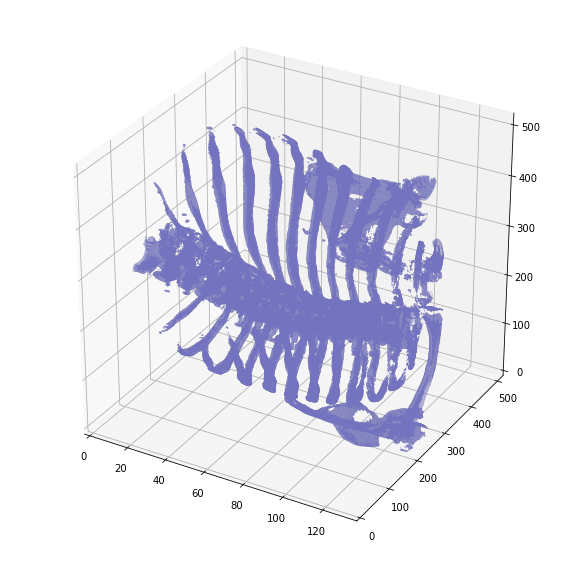

In [6]:
p = patients[0]
img_path = os.path.join(INPUT_FOLDER,
                    'Axial_{}.nii.gz'.format(p))
img = ni.load_image(img_path)
plot_3d(img.get_data(), 400)

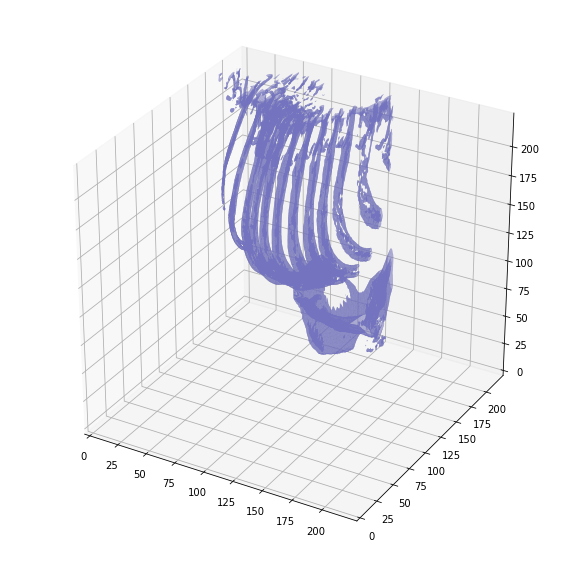

In [7]:
output_path = os.path.join(OUTPUT_FOLDER,
                           'Axial_{}.nii.gz'.format(p))
out_img = img = ni.load_image(output_path)
plot_3d(out_img.get_data(), 400)